<a href="https://colab.research.google.com/github/Topolewski-Kamil/dKnn/blob/main/keras_dis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/disseration/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/disseration


Import modules

In [2]:
%tensorflow_version 2.x
!pip install pynndescent

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model
import string
from bisect import bisect_left
from tensorflow.keras.losses import MSE

import pynndescent
import numpy as np
import h5py
from urllib.request import urlretrieve
import os
import seaborn as sns

Mnist dataset

In [3]:
num_classes = 10
input_shape = (28, 28, 1)

# import mnist data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale to [0, 1] size
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make images shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# keep raw labels in separate array
y_test_raw = y_test[750:10000]

# convert labels to one hot enconding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# split test set into calibration set
x_cal = x_test[0:750] 
y_cal = y_test[0:750]
x_test = x_test[750:10000]
y_test = y_test[750:10000]

Initialize CNN model

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding="same", activation="relu", input_shape=x_train.shape[1:]),
        layers.Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding="valid", activation="relu"),
        layers.Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding="valid", activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation=tf.nn.softmax),
    ]
)

batch_size = 500
epochs = 8

adam_opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 128)         295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         409728    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 710,218
Trainable params: 710,218
Non-trai

Train model


In [5]:
# try loading model from files
try:
  keras.backend.set_learning_phase(False)
  model = load_model('deepKNN_model.h5')
  print("loaded model successfully")

# otherwise train from scratch
except:
  print("failed to load model")
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1) #0.1
  model.save('deepKNN_model.h5')  # creates a HDF5 file
  print("saved model successfully")

loaded model successfully


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Evaluate model

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02765224687755108
Test accuracy: 0.9914594888687134


Generate Adversarial Examples

In [7]:
def generate_image_adversary(model, image, label, eps):

  # Make images shape (1, 28, 28, 1)
  image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)

  # record our gradients
  with tf.GradientTape() as tape:

    # start tracing image by the Tape
    tape.watch(image)

    #compute prediction
    pred = model(image)

    # compute loss
    loss = MSE(label, pred)

    # calculate the gradient of loss function 
    grad = tape.gradient(loss, image)

    # compute the sign of the gradient
    sign = tf.sign(grad)

    # create perturbation
    perturbation = sign * eps

    # apply perturbation to image
    adversary = (image + perturbation).numpy()

    # Make images shape (28, 28, 1)
    adversary = adversary.reshape(28, 28, 1)
    
    return adversary

In [8]:
def load_adversarial():
  epsilons.insert(0, 0.0)
  adversaries = {}
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    path = 'adv_datasets/adversaries' + eps_str + '.npy'
    adversaries[eps] = np.load(path)
  return adversaries

def save_adversarial(adversaries):
  for eps in epsilons:
    eps_str = str(eps)
    eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
    filename = 'adv_datasets/adversaries' + eps_str + '.npy'
    np.save(filename, adversaries[eps])

In [9]:
# pixel-wise perturbation amount 
epsilons = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]

# try loading adversarial examples from files
try:
  fgsm_adversarials = load_adversarial()
  print('loaded adversarial datasets successfully')

# otherwise generate adversarial examples
except:
  print('failed to load adversarial datasets')
  fgsm_adversarials = {}

  for eps in epsilons:
    adv = []
    for i in range(x_test.shape[0]):
      adv.append(generate_image_adversary(model, x_test[i], y_test[i], eps))
    fgsm_adversarials[eps] = np.array(adv)

  # add raw test set as 0.0 epsilon
  epsilons.insert(0, 0.0)
  fgsm_adversarials[0.0] = x_test

  save_adversarial(fgsm_adversarials)
  print('saved adversarial dataset successfully')

loaded adversarial datasets successfully


Test model on adversarial attacks

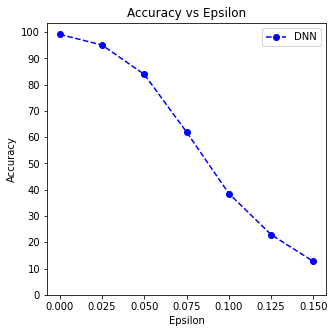

In [10]:
def plot_accuracy_vs_epsilon():
  accuracies_plot = []
  for eps in epsilons:
    adversary_score = model.evaluate(fgsm_adversarials[eps], y_test, verbose=0)
    accuracies_plot.append(adversary_score[1] * 100)

  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies_plot, linestyle='--', marker='o', color='b', label = 'DNN')

  plt.yticks(np.arange(0, 101, step=10))
  plt.xticks(np.arange(0, 0.16, step=0.025))
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epsilon")
  plt.legend()
  
plot_accuracy_vs_epsilon()
plt.show()

Plot some adversarial examples

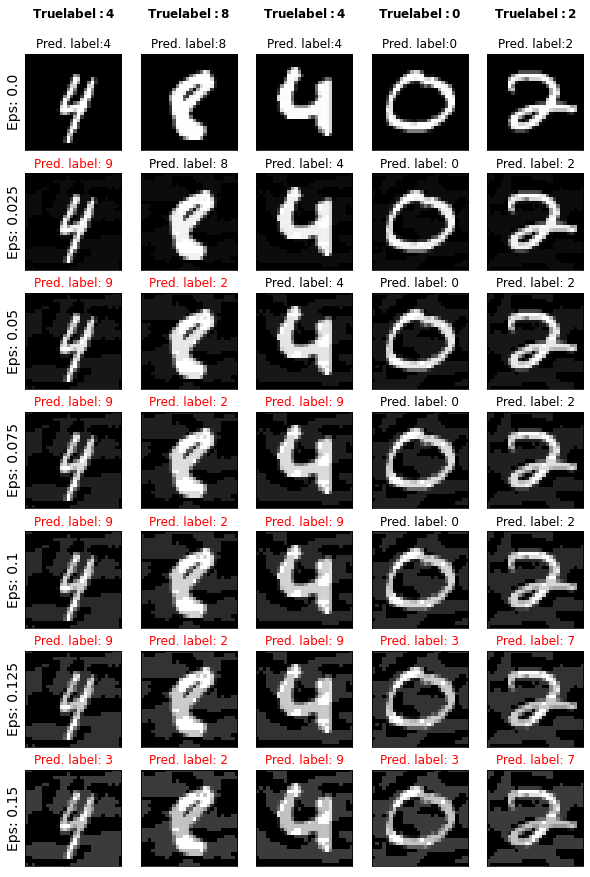

In [11]:
counter = 0
plt.figure(figsize=(10,15))

for eps in epsilons:
  adv_img = fgsm_adversarials[eps][10:15]
  true_label = y_test[10:15]

  adv_results = model.predict(fgsm_adversarials[eps][10:15])
  predicted_labels = []
  for result in adv_results:
    predicted_labels.append(np.argmax(result))

  for i in range(5):
      counter += 1
      plt.subplot(len(epsilons), 5, counter)
      plt.xticks([], [])
      plt.yticks([], [])

      if i == 0:
        plt.ylabel('Eps: '+ str(eps), fontsize=14)

      label = np.argmax(true_label[i])
      if predicted_labels[i] != label:
        incorrect_label = plt.title('Pred. label: ' + str(predicted_labels[i]))
        plt.setp(incorrect_label, color='r')
      else:
        if eps == 0.0:
          plt.title(r"$\bf{" + 'True label:' + str(label) + "}$" + '\n\nPred. label:' + str(predicted_labels[i]))
        else:
          plt.title('Pred. label: ' + str(predicted_labels[i]))

      plt.imshow(np.squeeze(adv_img[i]), cmap="gray")
plt.show()

KNN for patterns

In [12]:
# # reformat training data
# x_train_knn = np.squeeze(x_train, -1)
# x_train_knn = x_train_knn.reshape((60000, 784))

# # index training data
# index = pynndescent.NNDescent(x_train_knn)

# # prepare for faster query
# index.prepare()

# reformat test data
# x_test_knn = np.squeeze(x_test, -1)
# x_test_knn = x_test_knn.reshape((7500, 784))

# find neighbors for test data
# neighbors = index.query(x_test_knn)

# # create gold standard from KDTree ###
# from sklearn.neighbors import KDTree
# tree_index = KDTree(x_train)

# tree_neighbors = tree_index.query(x_test, k=10)

# def accuracy_per_query_point(approx_neighbors, true_neighbors):
#     approx_indices = approx_neighbors[0]
#     result = np.zeros(approx_indices.shape[0])
#     for i in range(approx_indices.shape[0]):
#         n_correct = np.intersect1d(approx_indices[i], true_neighbors[i]).shape[0]
#         result[i] = n_correct / true_neighbors.shape[1]
#     return result

# tree_N = np.load('test_true_neighbors.npy')

# accuracy_stats = accuracy_per_query_point(neighbors, tree_N)
# sns.set(rc={"figure.figsize":(10,6)})

# sns.distplot(accuracy_stats, kde=False)
# plt.title("Distribution of accuracy per query point")
# plt.xlabel("Accuracy")
# print(f"Average accuracy of {np.mean(accuracy_stats)}")

KNN for first CNN layer

Get activations on each layer

In [13]:
def get_activations(model, dataset):
    #function to get the layer wise output representation of the model for data x
    layer_output = []

    for i in [0,1,2,5]: # 0,1,2-convolutions layer, 5-dense layer
        layer = model.layers[i]
        l_op = K.function([model.layers[0].input], [layer.output])([dataset])[0]
        layer_output.append(l_op)

    reshaped_output_layer = []
    
    for output in layer_output[0:3]:
        reshaped_output_layer.append(output.reshape(output.shape[0], output.shape[1]*output.shape[2]*output.shape[3]))
        
    reshaped_output_layer.append(layer_output[3])
    
    for layer in reshaped_output_layer:
        # assert layer.dtype == np.float32
        layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)
    return(reshaped_output_layer)

Index trainingset knn

In [14]:
%%time
def index_layer(layer):
  layer_act = activations_train[layer]
  index_act = pynndescent.NNDescent(layer_act) # index training data
  index_act.prepare()# prepare for faster query
  return index_act

activations_train = get_activations(model, x_train)

index_act = {}
for layer in range (0,4):
  index_act[layer] = index_layer(layer)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 11min 42s, sys: 5.2 s, total: 11min 47s
Wall time: 3min 31s


Find Neigbours

In [15]:
k_neighbours = 75
def find_neighbours(activations, index, layer, knn_eps):
  act = activations[layer]
  neighbors = index.query(act, k=k_neighbours, epsilon=knn_eps)
  return neighbors

def correct_neighbours_count(neihgbours):
  correct_neighbours = [0] * (k_neighbours + 1)
  for i in range(0, neihgbours[0].shape[0]):
    correct = 0
    for j in neihgbours[0][i]:
      if (np.argmax(y_train[j]) == (np.argmax(y_test[i]))):
        correct += 1
    correct_neighbours[correct] += 1
  return correct_neighbours

def compare_neigbours(neighbours, layer, eps):
  plt.figure(figsize=(15,5))
  x_ax = np.arange(len(neighbours[layer][0.0]))
  plt.bar(x_ax-0.2, neighbours[layer][0.0], 0.4, label = 'Epsilon: 0.0')
  plt.bar(x_ax+0.2, neighbours[layer][eps], 0.4, label = 'Epsilon: ' + str(eps))

  plt.xlabel("Neigbours")
  plt.ylabel("Number of correct neigbours")
  plt.title("Number of correct neigbours on layer number: " + str(layer+1))
  plt.legend()

  plt.xticks(x_ax);
  plt.show() 

Get activations on each layer for all datasets

In [16]:
activations = {}
for eps in epsilons:
  activations[eps] = get_activations(model, fgsm_adversarials[eps])

In [17]:
%%time
# With GPU
# 7 min
neighbors = {}
for layer in range (0,4):
  neighbors[layer] = {} # useless?
  for eps in epsilons:
    neighbors[layer][eps] = find_neighbours(activations[eps], index_act[layer], layer, 0.1)

CPU times: user 5min 22s, sys: 1.64 s, total: 5min 23s
Wall time: 5min 19s


In [18]:
correct_neighbours = {}
for layer in range (0,4):
  correct_neighbours[layer] = {}
  for eps in epsilons:
    correct_neighbours[layer][eps] = correct_neighbours_count(neighbors[layer][eps])

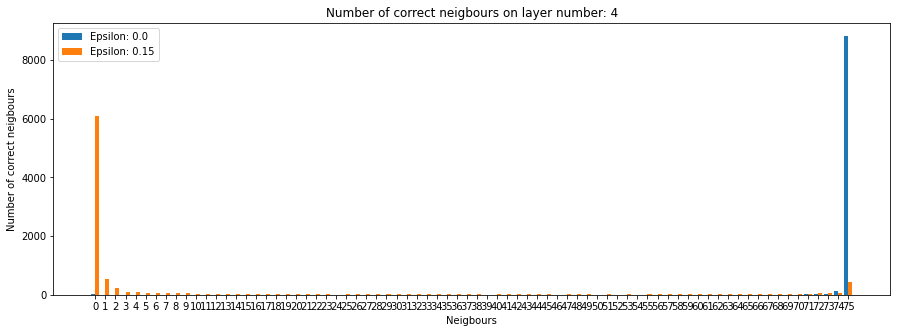

In [19]:
compare_neigbours(correct_neighbours, 3, 0.15)

Calibration set

In [20]:
activations_calib = get_activations(model, x_cal)
neigbours_calib = {}
for layer in range (0,4):
  neigbours_calib[layer] = find_neighbours(activations_calib, index_act[layer], layer, 0.1)[0]

In [21]:
# Returns how many neighbours does not match real label
def nonconformity_calibration(neihgbours_arr, y_true, y_predicted):
  nonconformity = []
  for i in range(0, neihgbours_arr.shape[0]):
    incorrect = 0
    for j in neihgbours_arr[i]:
      if (np.argmax(y_true[j]) != (np.argmax(y_predicted[i]))):
        incorrect += 1
    nonconformity.append(incorrect)
  return np.array(nonconformity)

In [22]:
# nonconformity of calib
nonconformity_calib = np.zeros(neigbours_calib[0].shape[0])
for layer in range (0,4):
  nonconformity_calib += nonconformity_calibration(neigbours_calib[layer], y_train, y_cal)

# sort
nonconformity_calib =  np.sort(nonconformity_calib)
# trim zeros
nonconformity_calib = np.trim_zeros(nonconformity_calib, trim='f')

Calculate p-values, credibility and predicted labels

In [23]:
# calculate_nonconformity for each class based on calibration
def calculate_nonconformity(eps):
  nonconformity_for_class = np.full((x_test.shape[0], num_classes), k_neighbours * 4, dtype=np.float32)

  for i in range(0, x_test.shape[0]):
    for layer in range(0,4):
      neighours_for_layer = neighbors[layer][eps][0]
      for neigh in neighours_for_layer[i]:
        nonconformity_for_class[i][np.argmax(y_train[neigh])] -= 1

  return nonconformity_for_class

def calculate_p_values(nonconformity_for_class, nonconformity):
  p_values = np.empty((x_test.shape[0], num_classes),  dtype=np.float32)
  for i in range(0, x_test.shape[0]):
    for j in range(0, num_classes):
      insert_index = bisect_left(nonconformity, nonconformity_for_class[i][j])
      p_values[i][j] = (nonconformity.shape[0] - insert_index) / nonconformity.shape[0]
  return p_values

def predict_labels(eps):
  knn_predicted_labels = []
  for i in range(0, x_test.shape[0]):
    knn_predicted_labels.append(np.argmin(nonconformity_for_class[eps][i]))
  return np.array(knn_predicted_labels)

In [24]:
nonconformity_for_class = {}
p_values = {}
knn_predicted_labels = {}
for eps in epsilons:
  nonconformity_for_class[eps] = calculate_nonconformity(eps)
  p_values[eps] = calculate_p_values(nonconformity_for_class[eps], nonconformity_calib)
  knn_predicted_labels[eps] = predict_labels(eps)

In [25]:
def calculate_performance_per_cred(confidence, predicted_labels):
  credibility = np.max(confidence, axis=1)
  distribution = np.zeros(10)
  correct_labels = np.zeros(10)

  for i in range(credibility.shape[0]):
    bin = credibility[i] // 0.1 / 10
    bin_index = int(bin*10)
    distribution[bin_index] += 1
    if (predicted_labels[i] == y_test_raw[i]):
      correct_labels[bin_index] += 1

  for i in range(correct_labels.shape[0]):
    if correct_labels[i] != 0 and distribution[i] != 0:
      correct_labels[i] /=  distribution[i]

  return distribution, correct_labels 

def plot_reliability(model_type, eps):

    if model_type == 'DkNN':
      confidence = p_values[eps]
      predicted_labels = knn_predicted_labels[eps]
    elif model_type == 'Softmax':
      softmax_probabilities = model.predict(fgsm_adversarials[eps])
      softmax_classes = softmax_probabilities.argmax(axis=-1)
      confidence = softmax_probabilities
      predicted_labels = softmax_classes

    bars_begin = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    bars_end = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    bars_center = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

    num_points, reliability_diag = calculate_performance_per_cred(confidence, predicted_labels)

    fig, ax1 = plt.subplots()
    ax1.bar(bars_center, reliability_diag, width=.1, alpha=0.8, edgecolor = "black")
    ax1.set_ylim([0, 1.])

    ax2 = ax1.twinx()

    ax2.plot(bars_center, num_points, color='r', linestyle='-', linewidth=6.0)

    plt.title("Reliability Diagram: " + model_type + ', eps: ' + str(eps))
    ax2.set_ylabel('Number of points in dataset', color='r')
    ax1.set_xlabel('Prediction Credibility')
    ax1.set_ylabel('Prediction Accuracy')
    ax2.tick_params(colors='r')
    plt.show()

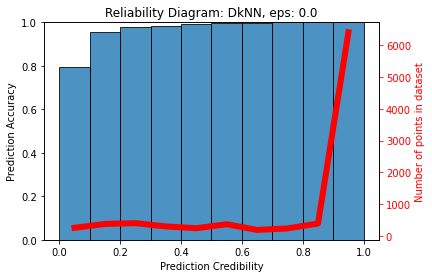

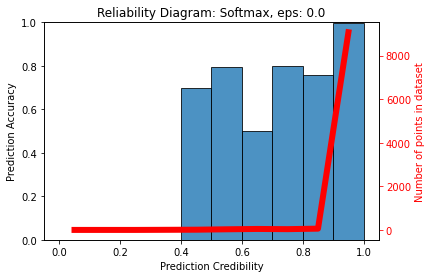

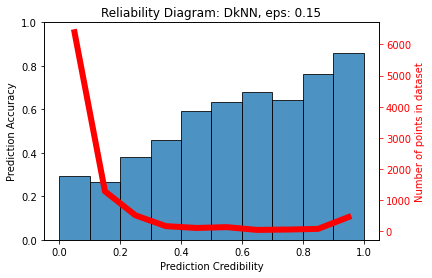

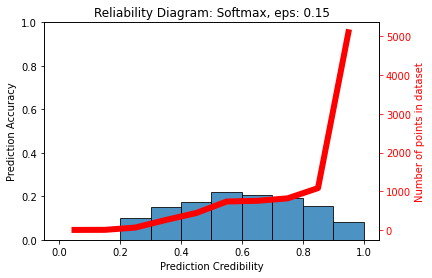

In [26]:
plot_reliability('DkNN', eps = 0.0)
plot_reliability('Softmax', eps = 0.0)
plot_reliability('DkNN', eps = 0.15)
plot_reliability('Softmax', eps = 0.15)

In [27]:
def test_model_accuracy(labels1, labels2):
  correct_labels = np.sum(labels1 == labels2)
  return correct_labels / labels1.shape[0] * 100

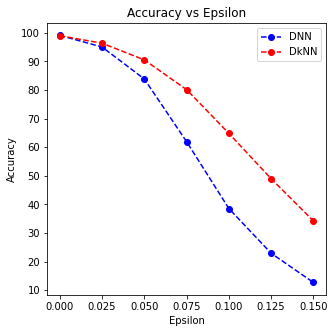

In [28]:
accuracies_plot_knn = []
for eps in epsilons:
  model_accuracy = test_model_accuracy(knn_predicted_labels[eps], y_test_raw)
  accuracies_plot_knn.append(model_accuracy)

plot_accuracy_vs_epsilon()
plt.plot(epsilons, accuracies_plot_knn, linestyle='--', marker='o', color='r', label = 'DkNN')
plt.legend()
plt.show()